<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

## Acute Inflammations

The `acute inflammations` was created by a medical expert as a data set to test the expert system, which will perform the presumptive diagnosis of two diseases of the urinary system. You can find out more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations).

Attribute information:

Inputs:
- Temperature of patient : 35C-42C
- Occurrence of nausea : yes/no
- Lumbar pain : yes/no
- Urine pushing (continuous need for urination) : yes/no
- Micturition pains : yes/no
- Burning of urethra, itch, swelling of urethra outlet : yes/no

Outputs:
- decision 1: Inflammation of urinary bladder : yes/no
- decision 2: Nephritis of renal pelvis origin : yes/no

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')
import numpy as np
import pandas as pd

dataset_url = 'https://archive.ics.uci.edu/static/public/184/acute+inflammations.zip'
csv_file = 'datasets/diagnosis.data'
tf.keras.utils.get_file(fname='acute+inflammations.zip',
    origin=dataset_url, extract=True, cache_dir=".")

cols = ['temp', 'nocc', 'lumbp', 'up', 'mict', 'bis', 'inflam', 'nephr']
df_raw = pd.read_csv(csv_file, encoding='utf-16', sep='\t', header=None, names=cols)
df_raw['temp'] = df_raw['temp'].str.replace(',', '.').astype(np.float32)
df_raw.info()
df_raw.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    120 non-null    float32
 1   nocc    120 non-null    object 
 2   lumbp   120 non-null    object 
 3   up      120 non-null    object 
 4   mict    120 non-null    object 
 5   bis     120 non-null    object 
 6   inflam  120 non-null    object 
 7   nephr   120 non-null    object 
dtypes: float32(1), object(7)
memory usage: 7.2+ KB


,temp,nocc,lumbp,up,mict,bis,inflam,nephr
115,41.400002,no,yes,yes,no,yes,no,yes
116,41.500000,no,no,no,no,no,no,no
117,41.500000,yes,yes,no,yes,no,no,yes
118,41.500000,no,yes,yes,no,yes,no,yes
119,41.500000,no,yes,yes,no,yes,no,yes


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')
from sklearn import model_selection

df_train, df_test = model_selection.train_test_split(
    df_raw, test_size=0.1, random_state=42)

inputs, outputs = {}, {}
inputs['temp'] = tf.keras.Input(name='temp', shape=(), dtype=tf.float32)
outputs['temp'] = tf.keras.layers.Discretization(
    bin_boundaries=[35, 36, 37, 38, 39, 40, 41])(inputs['temp'])
outputs['temp'] = tf.keras.layers.CategoryEncoding(
    num_tokens=7, output_mode='one_hot')(outputs['temp'])

for c in cols[1:]:
    inputs[c] = tf.keras.Input(name=c, shape=(), dtype=tf.string)
    outputs[c] = tf.keras.layers.StringLookup(max_tokens=2,
        vocabulary=df_raw[c].unique(), num_oov_indices=0)(inputs[c])

preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

features = cols[:-2]
labels = cols[-2:]
def features_labels(r):
    x = {k: v for k, v in r.items() if k in features}
    y = {k: v for k, v in r.items() if k in labels}
    return (x, y)

def df_to_ds(df, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=dict(df))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size=4)
    ds = ds.map(lambda x: preprocessing_model(x),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(map_func=features_labels).cache()\
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = df_to_ds(df=df_train, shuffle=True)
ds_test = df_to_ds(df=df_test)
ds_train.element_spec

({'temp': TensorSpec(shape=(None, 7), dtype=tf.float32, name=None),
  'nocc': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'lumbp': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'up': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'mict': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'bis': TensorSpec(shape=(None,), dtype=tf.int64, name=None)},
 {'inflam': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'nephr': TensorSpec(shape=(None,), dtype=tf.int64, name=None)})

In [20]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')

inputs, outputs, loss, metrics, loss_weights = {}, {}, {}, {}, {}

inputs['temp'] = tf.keras.Input(name='temp', shape=(7,), dtype=tf.float32)
for c in features[1:]:
    inputs[c] = tf.keras.Input(name=c, shape=(1,), dtype=tf.int64)

h = tf.keras.layers.Concatenate()([inputs[c] for c in features])

for c, w in zip(labels, [1., 0.2]):
    outputs[c] = tf.keras.layers.Dense(name=c, units=1,
        activation=tf.keras.activations.sigmoid)(h)
    loss[c] = tf.keras.losses.BinaryCrossentropy()
    metrics[c] = [tf.keras.metrics.BinaryAccuracy()]
    loss_weights[c] = w

training_model = tf.keras.Model(inputs=inputs, outputs=outputs)
training_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss=loss, metrics=metrics, loss_weights=loss_weights
)
training_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ temp (InputLayer)   │ (None, 7)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nocc (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lumbp (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mict (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bis (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 12)        │          0 │ temp[0][0],       │
│ (Concatenate)       │                   │            │ nocc[0][0],       │
│                     │                   │            │ lumbp[0][0],      │
│                     │                   │            │ up[0][0],         │
│                     │                   │            │ mict[0][0],       │
│                     │                   │            │ bis[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inflam (Dense)      │ (None, 1)         │         13 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nephr (Dense)       │ (None, 1)         │         13 │ concatenate_12[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26 (104.00 B)

 Trainable params: 26 (104.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = training_model.fit(x=ds_train, validation_data=ds_test,
    epochs=10)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - inflam_binary_accuracy: 0.3944 - loss: 0.8911 - nephr_binary_accuracy: 0.4068 - val_inflam_binary_accuracy: 0.5833 - val_loss: 0.8083 - val_nephr_binary_accuracy: 0.8333
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - inflam_binary_accuracy: 0.3944 - loss: 0.8791 - nephr_binary_accuracy: 0.5016 - val_inflam_binary_accuracy: 0.5833 - val_loss: 0.7965 - val_nephr_binary_accuracy: 0.8333
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - inflam_binary_accuracy: 0.3944 - loss: 0.8693 - nephr_binary_accuracy: 0.5016 - val_inflam_binary_accuracy: 0.5833 - val_loss: 0.7852 - val_nephr_binary_accuracy: 0.8333
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - inflam_binary_accuracy: 0.3944 - loss: 0.8599 - nephr_binary_accuracy: 0.5085 - val_inflam_binary_accuracy: 0.5833 - val_loss: 0.7744 - val_nephr_binary_accuracy: 0.8333
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - inflam_binary_accuracy: 0.3944 - loss: 0.8509 - nephr_binar

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

inputs = tf.keras.Input(shape=(28, 28), dtype=tf.float32)
h = tf.keras.layers.Rescaling(scale=1./255)(inputs)
outputs = tf.keras.layers.Reshape(target_shape=(784,))(h)
preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=64)
    ds = ds.map(map_func=lambda x, y: (preprocessing_model(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)

next(iter(ds_train))

(<tf.Tensor: shape=(64, 784), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(64,), dtype=uint8, numpy=
 array([4, 2, 4, 6, 9, 1, 4, 0, 5, 2, 1, 5, 5, 3, 3, 9, 6, 9, 9, 1, 4, 8,
        2, 8, 4, 7, 9, 2, 0, 4, 4, 0, 9, 4, 1, 4, 0, 7, 5, 4, 4, 8, 6, 8,
        6, 3, 0, 1, 8, 5, 1, 3, 1, 0, 9, 1, 1, 7, 7, 8, 9, 8, 0, 9],
       dtype=uint8)>)

In [16]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')

inputs = tf.keras.Input(shape=(784,))
h = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs)
h = tf.keras.layers.Dropout(rate=0.2)(h)
outputs = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)(h)
training_model = tf.keras.Model(inputs=inputs, outputs=outputs)
training_model.summary()

training_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)

@tf.function
def train_step(model, x, y):
    logs = {}
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = model.compute_loss(y=y, y_pred=y_pred)

    trainable_vars = model.trainable_variables
    grads = tape.gradient(target=loss,
        sources=trainable_vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(
        grads, trainable_vars))

    for metric in model.metrics:
        if metric.name=="loss":
            metric.update_state(values=loss)
        else:
            metric.update_state(y_true=y, y_pred=y_pred)

    metrics = [m.result() for m in model.metrics]
    logs = {f"train_{k}": v for k, v in metrics[1].items()}
    logs["train_loss"] = metrics[0]

    return logs

@tf.function
def test_step(model, x, y):
    y_pred = model(inputs=x, training=False)
    loss = model.compute_loss(y=y, y_pred=y_pred)

    for metric in model.metrics:
        if metric.name=="loss":
            metric.update_state(values=loss)
        else:
            metric.update_state(y_true=y, y_pred=y_pred)

    metrics = [m.result() for m in model.metrics]
    logs = {f"test_{k}": v for k, v in metrics[1].items()}
    logs["test_loss"] = metrics[0]

    return logs

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    patience=1)
callbacks = tf.keras.callbacks.CallbackList(model=model,
    callbacks=[reduce_lr], add_history=True)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import time

num_epochs = 10
start_time = time.time()
history = {
    "train_loss": [], "test_loss": [],
    "train_accuracy": [], "test_accuracy": []
}

logs = {}
callbacks.on_train_begin(logs=logs)

for epoch in range(num_epochs):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for x, y in ds_train:
        logs = train_step(model=training_model, x=x, y=y)
    history["train_loss"].append(logs["train_loss"].numpy())
    history["train_accuracy"].append(logs["train_accuracy"].numpy())

    for x, y in ds_test:
        logs = test_step(model=training_model, x=x, y=y)
    history["test_loss"].append(logs["test_loss"].numpy())
    history["test_accuracy"].append(logs["test_accuracy"].numpy())

    callbacks.on_epoch_end(epoch=epoch, logs=logs)

callbacks.on_train_end(logs=logs)
print("Time taken: %.2fs"%(time.time() - start_time))

Time taken: 35.79s


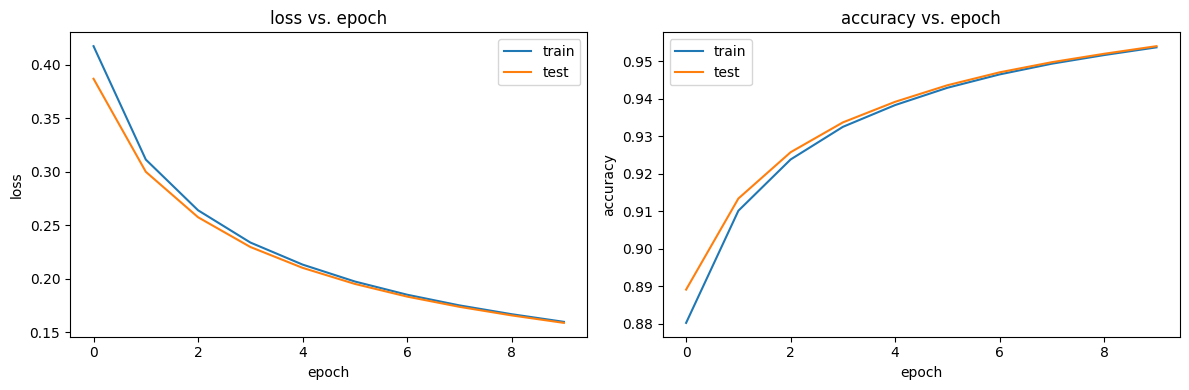

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for ax, m in zip(axes, ["loss", "accuracy"]):
    for l in ["train", "test"]:
        g = sns.lineplot(ax=ax, label=l, x=range(num_epochs), y=history[f"{l}_{m}"])
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

In [51]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')

inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)
inference_model.save('models/model.keras')


idx = 25
x_pred = np.reshape(a=x_test[idx], newshape=(1, 28, 28))
inference_model = tf.keras.models.load_model('models/model.keras')
y_pred = inference_model(x_pred)
print('y_true:', y_test[idx], 'y_pred:', np.argmax(y_pred))

y_true: 0 y_pred: 0
